In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-whoa299j
  Running command git clone --filter=blob:none --quiet https://github.com/deepvision-class/starter-code /tmp/pip-req-build-whoa299j
  Resolved https://github.com/deepvision-class/starter-code to commit e8d9fe711870a39796a2f8ad95538e57942d756f
  Preparing metadata (setup.py) ... done
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10266 sha256=dbcf0dc095b8a5192ac94e2152088a99b7b5643b33077b47bebfa893199632d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ntatd7s/wheels/c9/fa/82/64b6c443adccf6982835123e4300fc4420373c553439ff0ad5
Successfully built Colab-Utils


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
from coutils import rel_error
from collections import namedtuple
import matplotlib.pyplot as plt

SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225])

%matplotlib inline

In [3]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
#dtype = torch.cuda.FloatTensor
dtype = torch.FloatTensor

Good to go!


In [4]:
!wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/a4_styles.zip
!unzip a4_styles.zip && rm a4_styles.zip

--2023-09-27 17:13:29--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/a4_styles.zip
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2170872 (2.1M) [application/zip]
Saving to: ‘a4_styles.zip’

a4_styles.zip       100%[===================>]   2.07M  1.33MB/s    in 1.6s    

2023-09-27 17:13:32 (1.33 MB/s) - ‘a4_styles.zip’ saved [2170872/2170872]

Archive:  a4_styles.zip
   creating: styles/
  inflating: styles/tubingen.jpg     
  inflating: styles/the_scream.jpg   
  inflating: styles/starry_night.jpg  
  inflating: styles/muse.jpg         
  inflating: styles/composition_vii.jpg  
  inflating: style-transfer-checks.npz  


In [5]:
# helper function to process images:
def preprocess(img, size = 512):
  transform = T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize(mean = SQUEEZENET_MEAN.tolist(),
                  std = SQUEEZENET_STD.tolist()),
      T.Lambda(lambda x: x[None]),

  ])
  return transform(img)

def deprocess(img):
  transform = T.Compose([
      T.Lambda(lambda x: x[0]),
      T.Normalize(mean = [0,0,0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
      T.Normalize(mean = [-m for m in SQUEEZENET_MEAN.tolist()], std = [1,1,1]),
      T.Lambda(rescale),
      T.ToPILImage(),

  ])
  return transform(img)

def rescale(x):
  low, high = x.min(), x.max()
  x_rescaled = (x - low) / (high - low)
  return x_rescaled

def features_from_img(imgpath, imgsize):
  img = preprocess(PIL.Image.open(imgpath), size = imgsize)
  img_var = img.type(dtype)
  return extract_features(img_var, cnn), img_var

def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])

    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

#answers = dict(np.load('style-transfer-checks.npz'))


In [6]:
cnn = torchvision.models.squeezenet1_1(pretrained = True).features
#cnn = torchvision.models.vgg16_bn(pretrained = True).features
#cnn = torchvision.models.mobilenet_v3_large(pretrained = True).features
cnn.type(dtype)

# we don't want our cnn to update. Hence we set requires_grad = False
# for every parameter
for param in cnn.parameters():
  param.requires_grad = False

def extract_features(x, cnn):
  """
    Use the CNN to extract features from the input image x.

    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.

    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
  """

  features = []
  prev_feat = x
  # going from layer to layer
  for i, module in enumerate(cnn._modules.values()):
    next_feat = module(prev_feat)
    features.append(next_feat)
    prev_feat = next_feat
  return features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 71.7MB/s]


In [7]:
from torchsummary import summary
cnn1 = torchvision.models.squeezenet1_1(pretrained = True).features.cuda()
summary(cnn1, input_size = (3,124,124))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 61, 61]           1,792
              ReLU-2           [-1, 64, 61, 61]               0
         MaxPool2d-3           [-1, 64, 30, 30]               0
            Conv2d-4           [-1, 16, 30, 30]           1,040
              ReLU-5           [-1, 16, 30, 30]               0
            Conv2d-6           [-1, 64, 30, 30]           1,088
              ReLU-7           [-1, 64, 30, 30]               0
            Conv2d-8           [-1, 64, 30, 30]           9,280
              ReLU-9           [-1, 64, 30, 30]               0
             Fire-10          [-1, 128, 30, 30]               0
           Conv2d-11           [-1, 16, 30, 30]           2,064
             ReLU-12           [-1, 16, 30, 30]               0
           Conv2d-13           [-1, 64, 30, 30]           1,088
             ReLU-14           [-1, 64,

In [8]:
# computing loss
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.

    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).

    Returns:
    - scalar content loss
    """
    loss = 0.0
    for i in range(content_current.shape[1]):
        l = content_current[:,i].flatten(start_dim = 1, end_dim = -1) - content_original[:,i].flatten(start_dim = 1, end_dim = -1)
        loss += content_weight * torch.sum(l ** 2)

    return loss

In [9]:
answers = dict(np.load('style-transfer-checks.npz'))


In [10]:
def gram_matrix(features, normalize = True):
    """
    Compute the Gram matrix from features.

    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)

    Returns:
    - gram: PyTorch Tensor of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    """N, C, H, W = features.shape
    gram = torch.empty(size = (N, C, C)).to(features.device)

    flattened_features = features.flatten(start_dim = 2, end_dim = -1)
    for i in range(N):
     for j in range(C):
      for k in range(C):
         gram[i][j][k] = torch.dot(flattened_features[i][j], flattened_features[i][k])

    return gram"""
    a, b, c, d = features.shape
    feat = features.contiguous().view(a * b, c * d)
    return torch.mm(feat, feat.t()) / (a * b * c * d)

In [11]:
# compute style loss
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.

    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].

    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    loss = 0.0
    for j,i in enumerate(style_layers):
        gram_feat = gram_matrix(feats[i], normalize = True)
        loss += style_weights[j] * torch.sum((gram_feat - style_targets[j]) ** 2)
    return loss

In [12]:
# total-variation regularization
# aims to smooth out our output image
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.

    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.

    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    loss = 0.0
    vertical_up = img[:,:,:-1]
    vertical_down = img[:,:,1:]

    horizontal_up = img[:,:,:,:-1]
    horizontal_down = img[:,:,:,1:]

    loss = tv_weight * (((vertical_up - vertical_down) ** 2).sum() + \
                        ((horizontal_up - horizontal_down) ** 2).sum())

    return loss



In [13]:
def tv_loss(img, tv_weight):
  horizontal_loss = torch.pow(img[:,:,1:] - img[:,:,:-1], 2).sum()
  vertical_loss = torch.pow(img[:,:,:,1:] - img[:,:,:,:-1], 2).sum()
  return (horizontal_loss + vertical_loss) * tv_weight

In [14]:
class TotalVariationLoss(nn.Module):
  def __init__(self):
    super(TotalVariationLoss, self).__init__()

  def forward(self, x):
    horizontal_loss=torch.pow(x[...,1:,:]-x[...,:-1,:],2).sum()

    vertical_loss=torch.pow(x[...,1:]-x[...,:-1],2).sum()

    return (horizontal_loss+vertical_loss)/x.numel()

In [15]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.

    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.

    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    ##############################################################################
    # TODO: Compute total variation loss.                                        #
    # Your implementation should be vectorized and not require any loops!        #
    ##############################################################################
    # Replace "pass" statement with your code
    #
    nb_channels = img.shape[1]
    #
    h_filter = torch.tensor([[1., -1.]], dtype = img.dtype, device = img.device)
    h_filter = h_filter.view(1, 1, 1, 2).repeat(nb_channels, 1, 1, 1)
    w_filter = torch.tensor([[1.], [-1.]], dtype = img.dtype, device = img.device)
    w_filter = w_filter.view(1, 1, 2, 1).repeat(nb_channels, 1, 1, 1)
    #
    conv_h = torch.nn.functional.conv2d(img, h_filter, groups = nb_channels)
    conv_w = torch.nn.functional.conv2d(img, w_filter, groups = nb_channels)
    #
    loss = tv_weight * (torch.sum(conv_h ** 2) + torch.sum(conv_w ** 2))
    return loss
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

In [16]:
def tv_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)

    student_output = tv_loss(content_img, tv_weight)
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))

tv_loss_test(torch.from_numpy(answers['tv_out']).type(dtype))

Error is 0.000


In [21]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer,
                   content_weight, style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!

    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """

    # extract features from content image:
    content_img = preprocess(PIL.Image.open(content_image), size = image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # extract features from style image:
    style_img = preprocess(PIL.Image.open(style_image), size = style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
      style_targets.append(gram_matrix(feats[idx].clone()))

    # initialize output image:
    if init_random:
      img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
      img = content_img.clone().type(dtype)

    # We do want the gradient computed on our **noisy** image!
    img.requires_grad_()

    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)

    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()

    for t in range(200):
      if t < 190:
        img.data.clamp_(-1.5, 1.5)

      optimizer.zero_grad()

      feats = extract_features(img, cnn)

      c_loss = content_loss(content_weight, feats[content_layer], content_target)
      s_loss = style_loss(feats, style_layers, style_targets, style_weights)
      t_loss = tv_loss(img, tv_weight)
      loss = c_loss + s_loss + t_loss

      loss.backward()

      if t == decay_lr_at:
        optimizer = torch.optim.Adam([img], lr = decayed_lr)
      optimizer.step()
      if t % 50 == 0:
        print('Iteration {}'.format(t))
        plt.axis('off')
        plt.imshow(deprocess(img.data.cpu()))
        plt.show()


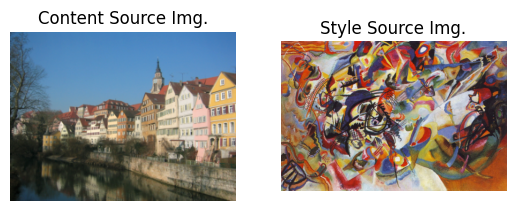

Iteration 0


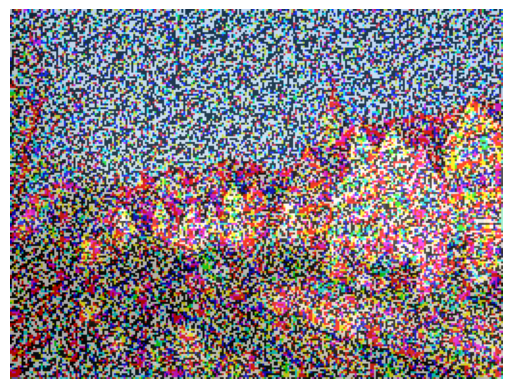

Iteration 50


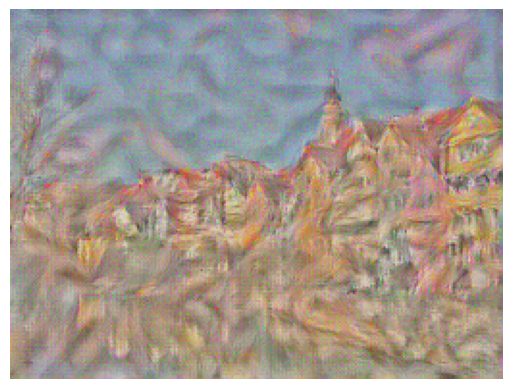

Iteration 100


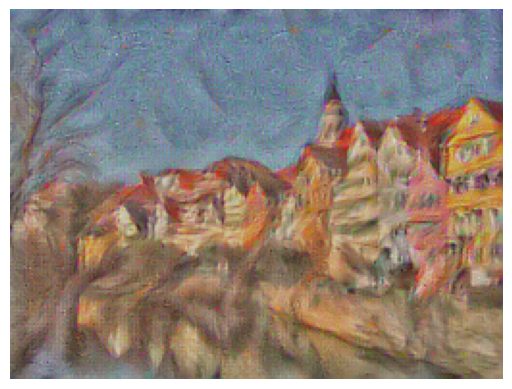

Iteration 150


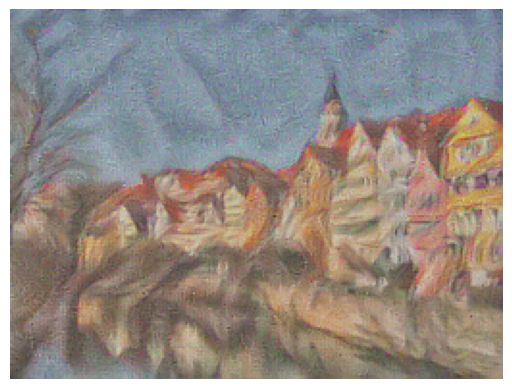

In [22]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2,
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

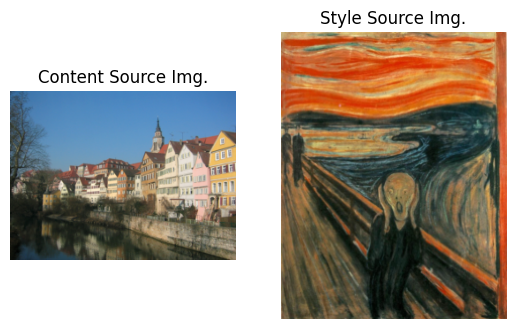

Iteration 0


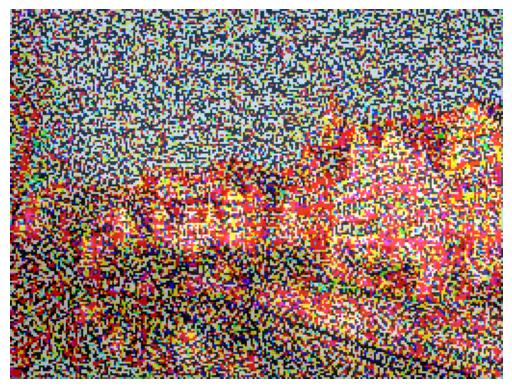

Iteration 50


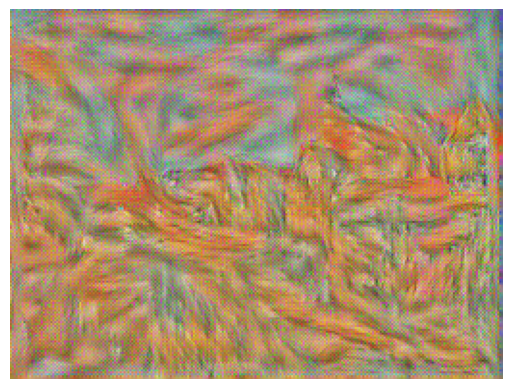

Iteration 100


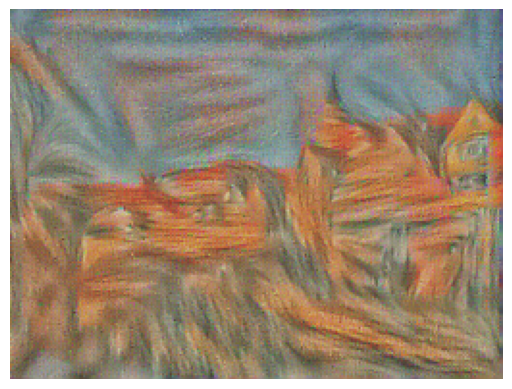

Iteration 150


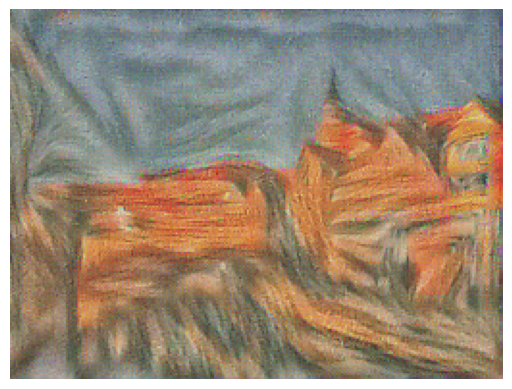

In [23]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

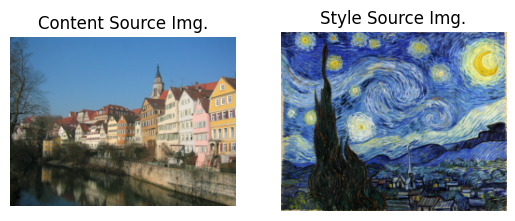

Iteration 0


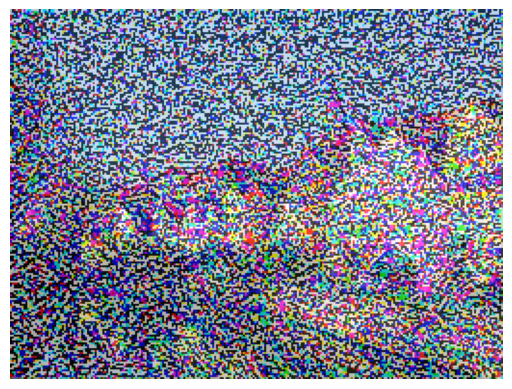

Iteration 50


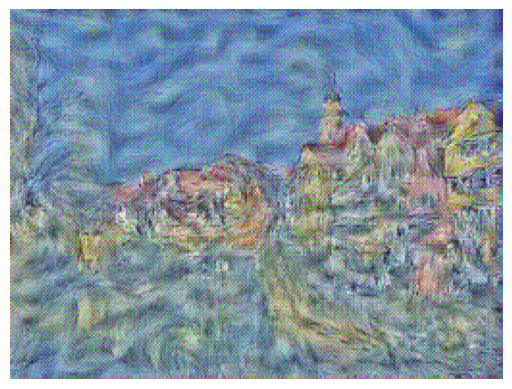

Iteration 100


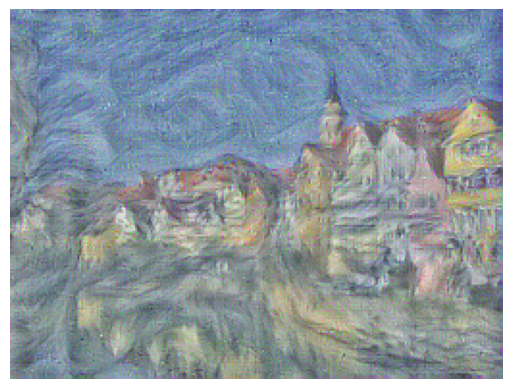

Iteration 150


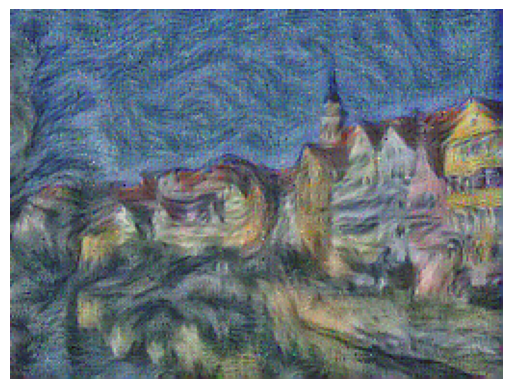

In [24]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)